# MAE 271: Lab 3 - Voice coil actuator installed on quarter car model
### Cooper Cook & Joshua Booth

## Problem Introduction
![alt text](Lab3_diagram.png)

The simulation problem below presents the sprung mass quarter car model that we have simulated before. This time, we have added a voice coil actuated inertial dampener on top of the sprung mass. This enables us to simulate and test how the current control on the voice coil can generate a force to accelerate the actuator mass that will theoretically react back on the sprung mass and mitigate the acceleration of the quarter car model. In this simulation, we test the system with a randomly varying road input and different levels of damping control on the actuator.

## Simulation Derivation
![alt text](Lab3_bond_graph.png)

With current control, $i_c$, we can generate a force $F_a$ that will accelerate the actuator mass $m_a$ such that the reaction force back onto the sprung mass $m_s$ is a desired force that will calm the motion of the sprung mass.


Deriving the equations, we will start with the capacitive element at zero junction at the tire, which has effort out, flow in. So, $F_t = k_t q_{us}$ because of our linear assumption. Also, $\dot{q}_{us} = v_{in} - v_{us}$, the signs and format of which are determined by the arrow directions.
- $F_t = k_t q_{us}$
- $\dot{q}_{us} = v_{in} - v_{us}$

Next, on the one element representing the unsprung mass velocity, we have an inertial element, which takes the effort output of the one junction, $\dot{p}_{us}$ where $p_{us} = \dot{q}_{us} m_{us}$, the normal force from the tire's capacitor displacement, and the gravitational force, $- m_{us} g$, which results in the equation $\dot{p}_{us} = - m_{us} g + F_t - F_s$, where $F_s$ is the force from the suspension module, which is yet to be calculated.
- $p_{us} = \dot{q}_{us} m_{us}$
- $\dot{p}_{us} = - m_{us} g + F_t - F_s$

Now at the suspension zero and one junctions, we have another one element with a resistive and capacitive element (a model of a spring and shock absorber). The flow here is $\dot{q}_s$, where the output is $F_s = b_s \dot{q}_s + k_s q_s$, and $\dot{q}_s = v_{us} - v_{s}$. So, adding up the forces here, we have $\dot{p}_s = -m_{s} g + F_s - F_a - F_{s_c}$, where $F_{s_a}$ is the force from the passive actuator and $F_{a}$ is the force from the active actuator, which are to be calculated next.
- $F_s = b_s \dot{q}_s + k_s q_s$
- $\dot{q}_s = v_{us} - v_{s}$
- $\dot{p}_s = -m_{s} g + F_s - F_a - F_{s_c}$

At the actuator, we have two systems: one with a passive actuator and another with the active actuator. The passive actuator is just like the suspension system, so $F_{s_a} = b_a \dot{q}_a + k_a q_a$ and $\dot{q}_a = v_s - v_a$. The active actuator is a little more complex because we are interested in the voice coil electrical power, not just the mechanical power. So, at the voice coil, we have a current flow source and a resistive element, feeding into a gyrator, which outputs the active actuator force. The active actuator force is then $F_a = T_c i_c$, and $e_c = R_w i_c$.
- $F_{s_a} = b_a \dot{q}_a + k_a q_a$
- $\dot{q}_a = v_s - v_a$
- $F_a = T_c i_c$
- $e_c = R_w i_c$

Finally, the actuated mass one junction experiences the forces from the passive and activate actuators, so its momentum derivative is $\dot{p}_a = - m_a g + F_{s_a} + F_a$ where $p_a = m_a v_a$.
- $\dot{p}_a = - m_a g + F_{s_a} + F_a$
- $p_a = m_a v_a$

Our final set of state equations for the system, including flow and effort, are:
- $\dot{q}_a = v_s - v_a$
- $\dot{q}_s = v_{us} - v_{s}$
- $\dot{q}_{us} = v_{in} - v_{us}$
- $\dot{p}_a = - m_a g + F_{s_a} + F_a$
- $\dot{p}_s = -m_{s} g + F_s - F_a - F_{s_c}$
- $\dot{p}_{us} = - m_{us} g + F_t - F_s$

These we will be adding into the derivative calculator function later.

According to the lab handout, tne control philosophy to try is to have the actuator oppose the velocity of the sprung mass. This is sort of what a damper to ground on the sprung mass would do. Thus a good thing to try to test the system is:
- $F_a = b_c v_s$
    or
- $i_c = \frac{b_c v_s}{T}$

There is a spring and damper acting on the actuator mass, which is necessary to keep the actuator more or less centered in the voice coil magnet and to hold the mass up under gravity.

## Code Setup
Since we plan to do several simulations and visualize them, in this section we define several functions that allow us to simplify how this is done.

### Define Derivative Function
To solve this non-linear system of ordinary differential equations, we need to start from an initial state, numerically integrate along the state derivatives to find the next state, and repeat as desired

For integration, we will use `scipy.integrate`'s `solve_ivp()`, which takes in a range of time (`t_span`) through which to integrate, a function handle (`func`) that takes in the time and state and returns the derivatives, and the initial condition (`initial`) of the state.

Since we wish to solve this problem using several different parameters, we will define a function `get_func()` that returns a function handle that we can pass to `solve_ivp()`. We also return a function that includes additional state information.

The simulator needs an input velocity, $v_{in}$, to excite the model as a representation of a bumpy road. Since we don't need road height/position for the simulation, we can generate the spatial slope of the road directly. We also need to ensure that the average slope of the road is zero. Thus, we will generate a random set of points along the road following a uniform distribution, subtract from every point the average of the set, and then create a simple linear interpolator from the new data to feed into the simulator.

In [1]:
from copy import deepcopy
import numpy as np


def get_func(params: dict[str, float]):
    '''
    Generate state derivative calculator functions for current simulation.
    '''
    # Make a copy of the input parameters to ensure the returned function
    # does not change when the original parameters dictionary changes
    params = deepcopy(params)

    # Extract parameters from dict
    g = params["g"]         # Gravitational constant (m/s^2)
    U = params["U"]         # Vehicle speed in x-direction (m/s)
    
    # Masses
    m_tot = params["m_tot"]     # Actuated mass (kg)
    msmus = params["msmus"]     # Sprung to unsprung mass ratio
    mams = params["mams"]       # Actuator to sprung mass ratio
    m_us = m_tot / (1 + msmus)  # Unsprung mass (kg)
    m_s = m_tot - m_us          # Sprung mass (kg)
    m_a = mams * m_s            # Actuator mass (kg)
    params["m_us"] = m_us
    params["m_s"] = m_s
    params["m_a"] = m_a

    # Passive Stiffness
    w_s = params["w_s"]     # Suspension natural frequency (rad/s)
    k_s = m_s * w_s**2      # Suspension stiffness (N/m)
    params["k_s"] = k_s
    w_wh = params["w_wh"]   # Tire wheel hop frequency (rad/s)
    k_t = m_us * w_wh**2    # Tire stiffness (N/m)
    params["k_t"] = k_t

    # Passive Damping
    zeta_s = params["zeta_s"]       # Passive damping ratio
    b_s = 2 * zeta_s * w_s * m_s    # Suspension damping (N·s/m)
    params["b_s"] = b_s

    # Actuator - Passive
    w_a = params["w_a"]         # Actuator frequency (rad/s)
    k_a = m_a * w_a**2          # Actuator stiffness (N/m)
    b_a = 2 * 0.1 * w_a * m_a   # Actuator damping (N·s/m)
    params["w_a"] = w_a
    params["k_a"] = k_a
    params["b_a"] = b_a

    # Actuator - Active
    zeta_c = params["zeta_c"]       # Active damping ratio
    T_c = params["T_c"]             # Voice coil coupling constant (N/A)
    R_c = params["R_c"]             # Voice coil winding resistance (Ohms)
    b_c = 2 * zeta_c * w_s * m_s    # Voice coil damping (N·s/m)
    params["b_c"] = b_c

    # Road
    road_delta_x = params["road_delta_x"]       # Distance between randomly generated road heights (m)
    road_length = params["road_length"]         # Road length (m)
    road_max_slope = params["road_max_slope"]   # Maximum instantaneous slope (dy/dx) of road
    X_i = np.arange(0, road_length+road_delta_x, road_delta_x)  # Generate road position vector
    road_slope_raw = np.random.random(np.shape(X_i))    # Generate random slope vector
    slope_i = road_max_slope * (road_slope_raw - np.mean(road_slope_raw)) # Scale and subtract mean from road slope vector
    def slope_interpolator(x: float):
        return np.interp(x, X_i, slope_i)

    # Get initial condition
    initial = [
        0,  # Actuator mass momentum
        0,  # Sprung mass momentum
        0,  # Unsprung mass momentum
        (m_a) * g / k_a,                # Actuator displacement
        (m_a + m_s) * g / k_s,          # Suspension displacement
        (m_a + m_s + m_us) * g / k_t,   # Tire displacement
        ]

    def func(t: float, state: list[float]):
        '''
        Calculate state derivative from current state.

        Parameters:
            t (float): Current time of simulation.
            state (list[float]): Current state of simulation.

        Returns:
            d_state (list[float]): Current state derivative.
            state_ext (dict[str, float]): Extended state information.
        '''
        # Create current extended state dict
        s: dict[str, float] = params.copy()
        s["t"] = t
        
        # Make a copy of state variables in case they get changed
        state = deepcopy(state)
        p_a = state[0]  # Actuator mass momentum
        p_s = state[1]  # Sprung mass momentum
        p_us = state[2] # Unsprung mass momentum
        q_a = state[3]  # Actuator displacement
        q_s = state[4]  # Suspension displacement
        q_t = state[5]  # Tire displacement
        s["p_a"] = p_a
        s["p_s"] = p_s
        s["p_us"] = p_us
        s["q_a"] = q_a
        s["q_s"] = q_s
        s["q_t"] = q_t

        # Position of road and its derivatives
        slope_interp = deepcopy(slope_interpolator)
        X = U * t   # vehicle velocity x time
        Y = np.zeros_like(X)
        dYdX = slope_interp(X)
        s["X"] = X
        s["Y"] = Y
        s["dYdX"] = dYdX

        # Velocities
        v_a = p_a / m_a     # Actuator mass velocity
        v_s = p_s / m_s     # Sprung mass velocity
        v_us = p_us / m_us  # Unsprung mass velocity
        v_in = U * dYdX            # Tire input velocity
        s["v_a"] = v_a
        s["v_s"] = v_s
        s["v_us"] = v_us
        s["v_in"] = v_in

        # Voice Coil Current
        i_c = b_c * v_s / T_c   # Voice coil input current (A)
        e_c = R_c * i_c         # Voice coil input voltage (V)
        P_c = i_c * e_c         # Voice coil power (W)
        s["i_c"] = i_c
        s["e_c"] = e_c
        s["P_c"] = P_c

        # Gravitational Force
        F_g_a = -m_a * g    # Actuator mass gravitational force
        F_g_s = -m_s * g    # Sprung mass gravitational force
        F_g_us = -m_us * g  # Unsprung mass gravitational force
        s["F_g_a"] = F_g_a
        s["F_g_s"] = F_g_s
        s["F_g_us"] = F_g_us

        # Actuator Force
        F_b_a = b_a * (v_s - v_a)   # Actuator damping force
        F_s_a = k_a * q_a           # Actuator spring force
        F_vc = T_c * i_c            # Voice coil force
        F_a = F_b_a + F_s_a + F_vc  # Total actuator force
        s["F_b_a"] = F_b_a
        s["F_s_a"] = F_s_a
        s["F_vc"] = F_vc
        s["F_a"] = F_a
        
        # Suspension Force
        F_b_s = b_s * (v_us - v_s)  # Suspension damping force
        F_s_s = k_s * q_s           # Suspension spring force
        F_s = F_b_s + F_s_s         # Total suspension force
        s["F_b_s"] = F_b_s
        s["F_s_s"] = F_s_s
        s["F_s"] = F_s
        
        # Tire Force
        F_t = k_t * q_t if q_t > 0 else 0   # Prevent tire sticking the ground
        s["F_t"] = F_t

        # State Derivatives
        d_p_a = F_g_a + F_a
        d_p_s = F_g_s + F_s - F_a
        d_p_us = F_g_us + F_t - F_s
        d_q_a = v_s - v_a
        d_q_s = v_us - v_s
        d_q_t = v_in - v_us
        s["d_p_a"] = d_p_a
        s["d_p_s"] = d_p_s
        s["d_p_us"] = d_p_us
        s["d_q_a"] = d_q_a
        s["d_q_s"] = d_q_s
        s["d_q_t"] = d_q_t

        # Acceleration
        s["a_a"] = d_p_a / m_a
        s["a_s"] = d_p_s / m_s
        s["a_us"] = d_p_us / m_us

        # Concatenate state derivatives
        d_state: list[float] = [
            d_p_a,
            d_p_s,
            d_p_us,
            d_q_a,
            d_q_s,
            d_q_t, # Don't worry, this is a float, not an NDArray
            ]

        return d_state, s

    def func_wrap(t: float, state: list[float]):
        """
        Since solve_ivp() needs a function that only returns the state
        derivatives, we create a wrapper for func() that discards the rest of
        the state and returns only the state derivatives
        """
        d_state, _ = func(t, state)
        return d_state

    return func, func_wrap, initial

### Propagate Solution Using `solve_ivp()`
Now that we have a function that calculates the state derivatives given the state, we need to propagate the solution throughout time. The function `solve_problem()` was designed to use the `get_func()` function we defined earlier, calculate the solution using `scipy.integrate`'s `solve_ivp()`, and consolidate the interesting parts of the solution and the parameters given to define it. This is unchanged from the previous lab assignment.

In [2]:
from scipy.integrate import solve_ivp
import pandas as pd
import numpy as np


def solve_problem(
        params: dict[str, float],
        t_eval: np.ndarray,
        name: str,
        rtol: float = 1e-12,
        atol: float = 1e-12,
    ):

    func, func_wrap, initial = get_func(params)
    output = solve_ivp(
        func_wrap,
        (min(t_eval), max(t_eval)),
        initial,
        t_eval=t_eval,
        method="RK45",
        rtol=rtol,
        atol=atol,
    )

    ts = output.t
    ys = output.y

    states: list[dict[str, float]] = []
    for t, y in zip(ts, ys.T):
        _, state = func(t, y)
        states.append(state)

    df = pd.DataFrame(states)

    solution = {
        "params": params.copy(),
        "data": df,
        "name": name,
    }

    return solution


### Define Plotting Functions
To visualize the solutions, we can create a plot of the sprung mass acceleration and actuator displacement throughout the simulation. Since we have several solutions we would like to plot together, we create functions to consolidate the code. `plot_time()` takes in a list of dictionaries outputted from `solve_problem()`.

In [3]:
import matplotlib.pyplot as plt


def plot_time(solutions):
    fig = plt.figure()
    ax1 = plt.subplot()
    ax2 = ax1.twinx()
    num_solutions = len(solutions)
    for i, solution in enumerate(solutions):
        name = solution["name"]
        df = solution["data"]

        t_vals = df.get("t").to_numpy()
        a_s_vals = df.get("a_s").to_numpy()     # Sprung mass acceleration
        q_a_vals = df.get("q_a").to_numpy()     # Actuator displacement
        P_c_vals = df.get("P_c").to_numpy()     # Voice coil power

        rms_a_s = np.sqrt(np.mean(a_s_vals**2))             # Sprung mass acceleration RMS
        rms_P_c = np.sqrt(np.mean(P_c_vals**2))             # Voice coil power RMS
        max_q_a = np.max(np.abs(q_a_vals - q_a_vals[0]))    # Maximum actuator displacement from initial

        print(f"a_s RMS is {rms_a_s} for {name}")
        print(f"P_c RMS is {rms_P_c} for {name}") 
        print(f"Max delta q_a is {max_q_a} for {name}") 
        
        ax1.plot(t_vals, a_s_vals, c=(1, 0.3 + (1-0.3)*i/(num_solutions-1), 0), label=f"Sprung Mass Acceleration: {name}")
        ax2.plot(t_vals, q_a_vals - q_a_vals[0], c=(0, 0.3 + (1-0.3)*i/(num_solutions-1), 1), label=f"Actuator Displacement From Start: {name}")

    lines = ax1.get_lines() + ax2.get_lines()

    plt.legend(lines, [l.get_label() for l in lines])
    plt.title("Sprung Mass Acceleration and Actuator Displacement")
    plt.xlabel("time (s)")
    ax1.set_ylabel("accleration (m/s^2)")
    ax2.set_ylabel("displacement (m)")
    
    return fig


## Simulation
To evaluate the effectiveness of the system, we can at least:
1. compare the system without the actuator to the system with the actuator while remaining under $1$ kw of RMS input power and $\pm 8$ cm from the starting displacement;
2. plot sprung mass acceleration, $a_s$, and displacement across the actuator, $q_a$, to compare instantaneous acceleration along with its relation to actuator displacement; and
3. vary winding resistance ($R_w$), actuator mass ($m_a$), actuator frequency (stiffness of actuator spring, $b_c$), and the coupling constant of the voice coil ($T_c$).
We can expect that reasonable ranges of $R_w$, $T_c$, and $m_a$ and other constraints, $q_a$ and $P_c$, are as follows:
- $0.001 \le R_w \le 0.01$ Ohms
- $1.0 \le T_c \le 10$ N/A
- $m_a \le 0.04m_s$
- $|q_a-q_{a_0}| \le 8$ cm
- $P_{c_{RMS}} \le 1$ kW

In order to maximize the system's potential, we would like to place the constraints within the problem's state equations. First, we will look at the actuator force, $F_a$:
- Since $P_{c_{RMS}}$ ($= i_c R_w$) is a constraint, we would like to increase the system's efficiency as much as possible. So, we will set $R_w$ to its minimum reasonable value, $0.001 \Omega$. 
- In our state equations, the force of the actuator is directly proportional to $i_c$, scaled by $T_c$. Increasing $T_c$ to its maximum value of $10\frac{N}{A}$ will maximize the potential value of $F_a$.
This leaves $m_a$ and $b_c$ to vary. We can tune $m_a$ directly to explore the effectiveness of the system, but $b_c$ ($= 2\zeta_c \omega_s m_s$) will be varied by $\zeta_c$ because $\omega_s$ and $m_s$ are defined and fixed.

In [4]:
import numpy as np


# -----------------------------
# Initial Global Parameters
# -----------------------------
params: dict[str, float] = {}

# Constants
params["g"] = 9.8  # gravity (m/s^2)

# Mass
params["m_tot"] = 3000.0 / 2.2  # Total vehicle mass (lbs -> kg)
params["msmus"] = 5.0           # Sprung to unsprung mass ratio
params["mams"] = 0.04          # Actuator to sprung mass ratio

# Damping ratios
params["zeta_s"] = 0.0  # Passive damping ratio
params["zeta_c"] = 0.7  # Active damping ratio

# Suspension
params["w_a"] = 2 * np.pi * 5   # Actuator natural frequency (rad/s)
params["w_s"] = 2 * np.pi * 1.2 # Suspension natural frequency (Hz -> rad/s)
params["w_wh"] = 2 * np.pi * 8  # Tire / wheel hop frequency (Hz -> rad/s)

# Voice coil parameters
params["R_c"] = 0.001   # Winding resistance (Ohm)
params["T_c"] = 10.0     # Coupling constant (N/A)

# Vehicle velocity
params["U"] = 40 * 0.46 # Vehicle speed (mph -> m/s)

# Road
params["road_delta_x"] = 0.5        # Distance between randomly generated road heights (m)
params["road_length"] = 500         # Road length (m)
params["road_max_slope"] = 0.005    # Maximum instantaneous slope (dy/dx) of road

# Time
t_start: float = 0
t_end: float = 5
t_increment: float = 0.001

t_span = (t_start, t_end)
t_eval = np.arange(min(t_span), max(t_span)+t_increment, t_increment)


### Basic Run Cases
Before exploring values of $\zeta_c$ and $m_a$, we will run a simple comparison to see how well the proposed system works compared to a baseline, unpowered case.  


a_s RMS is 0.41618393850260355 for baseline
P_c RMS is 0.0 for baseline
Max delta q_a is 0.001248919895303919 for baseline
a_s RMS is 0.42014182740771494 for zeta_c=0.7
P_c RMS is 8.399563708595235 for zeta_c=0.7
Max delta q_a is 0.03941085698363954 for zeta_c=0.7


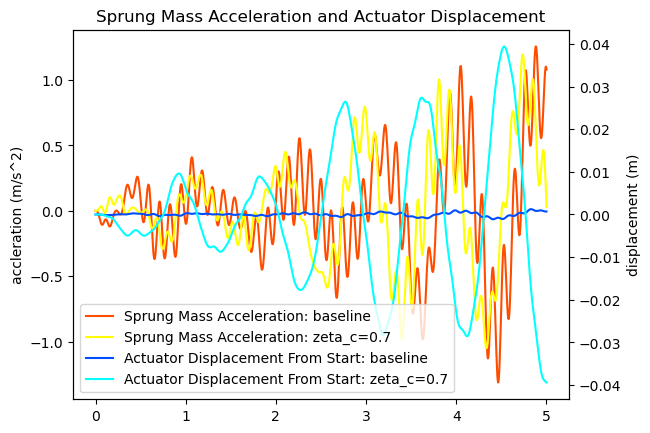

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"

# Time
t_start: float = 0
t_end: float = 5
t_increment: float = 0.005

t_span = (t_start, t_end)
t_eval = np.arange(min(t_span), max(t_span)+t_increment, t_increment)

# Run simulations
solutions: list[str, dict[str, float]] = []
params["zeta_c"] = 0
solutions.append(solve_problem(params, t_eval, "baseline"))
params["zeta_c"] = 0.7
solutions.append(solve_problem(params, t_eval, "zeta_c=0.7"))

fig = plot_time(solutions)

Seen above with the starting parameters, we can see that the system does draw power when the damping ratio is non-zero, however the system appears to be unstable when enabled, which would not be good for a car ride. In fact, the RMS sprung mass acceleration actually _increases_ compared to baseline when enabled. This could just be a tuning issue, so let's do that parameter sweep we mentioned earlier.

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed
from itertools import product
from tqdm import tqdm

# Time
t_start: float = 0
t_end: float = 1.5
t_increment: float = 0.005 # visualization time step duration (sec)

t_span = (t_start, t_end)
t_eval = np.arange(min(t_span), max(t_span)+t_increment, t_increment)

num_mass_ratios = 10
num_damping_ratios = 10
mass_ratios = np.linspace(0, 0.04, num_mass_ratios)
damping_ratios = np.linspace(0, 1.4, num_damping_ratios)

F, A = np.meshgrid(mass_ratios, damping_ratios)
T = np.zeros_like(A)

pbar = tqdm(total=num_mass_ratios*num_damping_ratios)

def process(params: dict, i, j, mass_ratio, damping_ratio):
    params.copy()
    params["mams"] = mass_ratio
    params["zeta_c"] = damping_ratio
    solution = solve_problem(params, t_eval, "sweep")

    a_s_vals = solution["data"]["a_s"]
    P_c_vals = solution["data"]["P_c"]
    q_a_vals = solution["data"]["q_a"]
    rms_a_s = np.sqrt(np.mean(a_s_vals**2))             # Sprung mass acceleration RMS
    rms_P_c = np.sqrt(np.mean(P_c_vals**2))             # Voice coil power RMS
    max_q_a = np.max(np.abs(q_a_vals - q_a_vals[0]))    # Maximum actuator displacement from initial

    # Check whether the current solution is out of bounds for this problem
    if rms_P_c > 1000:
        rms_a_s = np.nan
    elif max_q_a > 0.08:
        rms_a_s = np.nan

    result = rms_a_s
    pbar.update()
    return result

results = {}
with ThreadPoolExecutor(max_workers=4) as executor:
    for j, i in product(range(num_mass_ratios), range(num_damping_ratios)):
        mass_ratio = F[i, j]
        damping_ratio = A[i, j]

        results[executor.submit(process, params, i, j, mass_ratio, damping_ratio)] = [i, j]

    for future in as_completed(results):
        i, j = results[future]
        T[i, j] = future.result()

T_min, T_max = T.min(), T.max()

fig, ax = plt.subplots()

c = ax.pcolormesh(F, A, T, cmap='RdBu', vmin=T_min, vmax=T_max)
# set the limits of the plot to the limits of the data
ax.axis([F.min(), F.max(), A.min(), A.max()])
ax.set_title('RMS Sprung Mass Acceleration')
ax.set_xlabel("Mass Ratio (m_a/m_s)")
ax.set_ylabel("Damping Ratio")
fig.colorbar(c, ax=ax)


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_36306/2785758092.py:71: RuntimeWarning: invalid value encountered in scalar divide
  (m_a) * g / k_a,                # Actuator displacement
 54%|█████▍    | 54/100 [03:07<02:45,  3.60s/it]

## Conclusions
While an interesting idea, in our simulations, the voice coil actuated damping mass was not effective at reducing vibrations.
